ref: https://github.com/jojonki/pu-learning/blob/master/pu.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report

# Data generation

In [2]:
np.random.seed(42)
n_positives = 500
n_negatives = 1000
test_ratio = 0.2
unlabeled_ratio = 0.6
n = n_positives + n_negatives

# generate examples
mu1 = [1, 1]
mu2 = [-2, -2]
sigma1 = np.array([[0.7, 0.3], [0.3, 2.0]])
sigma2 = np.array([[1.0, -0.4], [-0.4, 1.0]])
X = np.r_[
    np.random.multivariate_normal(mu1, sigma1, n_positives),
    np.random.multivariate_normal(mu2, sigma2, n_negatives)
]
y = np.concatenate([np.repeat(1, n_positives), np.repeat(0, n_negatives)])

# split them
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=test_ratio)

# make some positives unlabeled
y_train_original = y_train.copy()
y_train_pos_ind = np.where(y_train > 0)[0]
n_unlabeled = int(len(y_train_pos_ind) * unlabeled_ratio)
print(f'make {n_unlabeled}/{len(y_train_pos_ind)} positive samples unlabeled.')
y_train_unlabeled_ind = np.random.choice(y_train_pos_ind, size=n_unlabeled, replace=False)
y_train[y_train_unlabeled_ind] = 0

make 237/396 positive samples unlabeled.


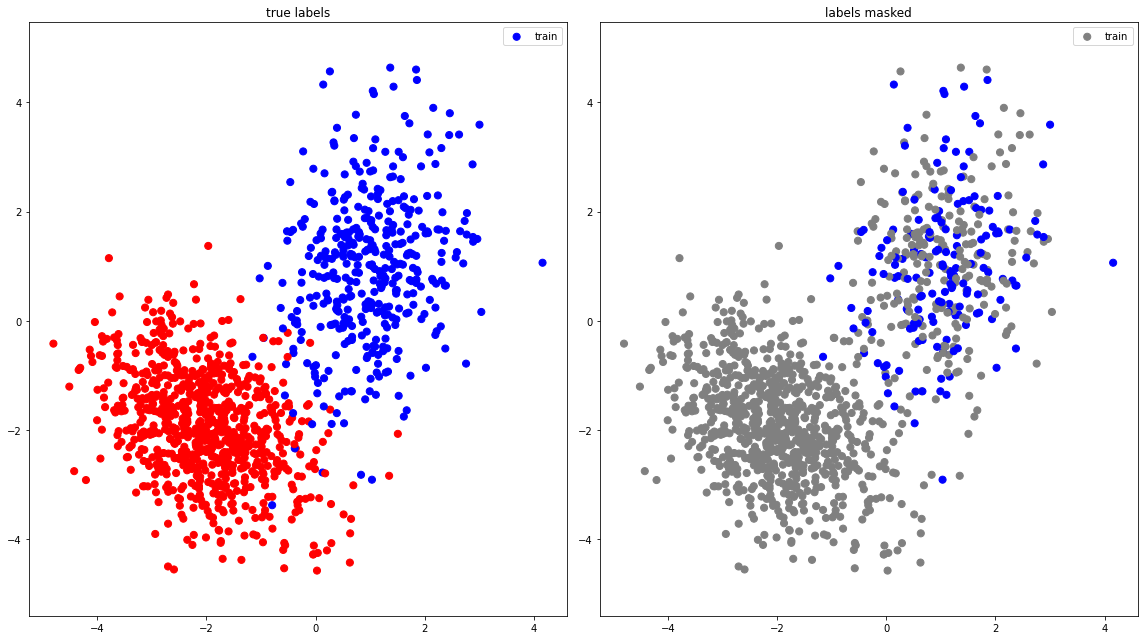

In [3]:
plt.figure(figsize=(16, 9))

plt.subplot(1, 2, 1)
plt.scatter(X_train[:,0], X_train[:,1], s=50, color=[['red', 'blue'][y] for y in y_train_original], label='train')
plt.axis('equal')
plt.title('true labels')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_train[:,0], X_train[:,1], s=50, color=[['gray', 'b'][y] for y in y_train], label='train')
plt.ylim(np.min(y), np.max(y))
plt.xlim(np.min(X), np.max(X))
plt.axis('equal')
plt.title('labels masked')
plt.legend()

plt.tight_layout()
plt.show()

# Classify simply by logistic regression

In [4]:
n_folds = 10

clf = SGDClassifier(loss='log', penalty='l2')
params = {'alpha': np.logspace(-5, 0, 6)}

gscv = GridSearchCV(clf, cv=n_folds, param_grid=params, n_jobs=-1)
gscv.fit(X_train, y_train)
print('best parameters:', gscv.best_params_)

y_pred = gscv.predict(X_test)
print(classification_report(y_test, y_pred))

best parameters: {'alpha': 1.0}
              precision    recall  f1-score   support

           0       0.66      1.00      0.79       196
           1       1.00      0.01      0.02       104

    accuracy                           0.66       300
   macro avg       0.83      0.50      0.41       300
weighted avg       0.77      0.66      0.52       300



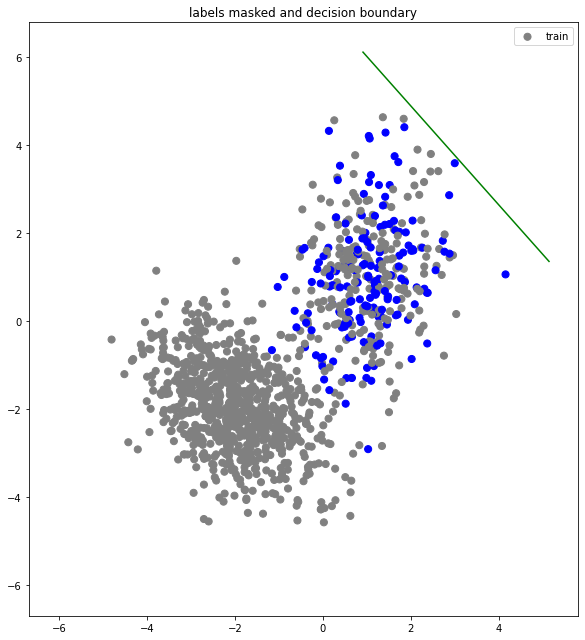

In [5]:
plt.figure(figsize=(16, 9))

plt.subplot(1, 2, 1)
plt.scatter(X_train[:,0], X_train[:,1], s=50, color=[['gray', 'b'][y] for y in y_train], label='train')

offset = 1.0
XX, YY = np.meshgrid(
    np.linspace(X[:, 0].min()-offset, X[:, 0].max()+offset, 100),
    np.linspace(X[:, 1].min()-offset, X[:, 1].max()+offset, 100)
)
Z = gscv.decision_function(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
plt.contour(XX, YY, Z, levels=[0.0], colors='g')

plt.title('labels masked and decision boundary')
plt.legend()
plt.axis('equal')

plt.tight_layout()
plt.show()

# Estimate lebeled/unlabeled

In [6]:
class PUSampler:
    def __init__(self, g, n_folds=10):
        self.g = g
        self.n_folds = n_folds

    def fit(self, X, s):
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        c_all = []
        for train_idx, test_idx in skf.split(X, s):
            self.g.fit(X[train_idx], s[train_idx])
            c = self.g.predict_proba(X[test_idx][s[test_idx]==1])[:,1].mean()
            c_all.append(c)
        
        c_mean = np.array(c_all).mean()
        print('c_mean:', c_mean)
        self.c = c_mean
    
    def sample(self, X, s):
        if not hasattr(self, 'c'):
            self.fit(X, s)

        X_positive = X[s==1]
        X_unlabeled = X[s==0]
        n_positive = X_positive.shape[0]
        n_unlabeled = X_unlabeled.shape[0]

        X_train = np.r_[X_positive, X_unlabeled, X_unlabeled]
        y_train = np.concatenate([np.repeat(1, n_positive), np.repeat(1, n_unlabeled), np.repeat(0, n_unlabeled)])

        p_unlabeled = self.g.predict_proba(X_unlabeled)[:,1]
        w_positive = ((1 - self.c) / self.c) * (p_unlabeled / (1-p_unlabeled))
        w_negative = 1 - w_positive
        sample_weight = np.concatenate([np.repeat(1.0, n_positive), w_positive, w_negative])
        return X_train, y_train, sample_weight

In [7]:
g = GridSearchCV(
    SGDClassifier(loss='log', penalty='l2'),
    cv=n_folds,
    param_grid={'alpha': np.logspace(-5, 0, 6)},
    n_jobs=-1
)
pu = PUSampler(g)
X_train_new, y_train_new, sample_weight = pu.sample(X_train, y_train)

c_mean: 0.30739880134665665


In [8]:
gscv = GridSearchCV(clf, cv=n_folds, param_grid=params, n_jobs=-1)
gscv.fit(X_train_new, y_train_new, sample_weight=sample_weight)

y_pred = gscv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       196
           1       0.92      1.00      0.96       104

    accuracy                           0.97       300
   macro avg       0.96      0.98      0.97       300
weighted avg       0.97      0.97      0.97       300



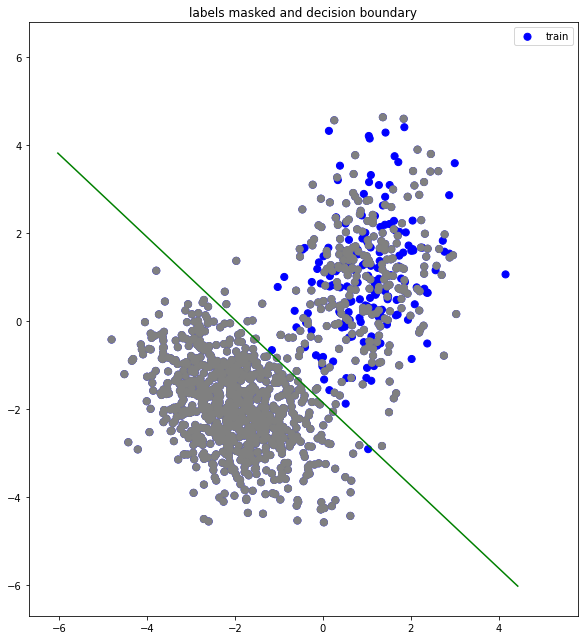

In [9]:
plt.figure(figsize=(16, 9))

plt.subplot(1, 2, 1)
plt.scatter(X_train_new[:,0], X_train_new[:,1], s=50, color=[['gray', 'b'][y] for y in y_train_new], label='train')

offset = 1.0
XX, YY = np.meshgrid(
    np.linspace(X[:, 0].min()-offset, X[:, 0].max()+offset, 100),
    np.linspace(X[:, 1].min()-offset, X[:, 1].max()+offset, 100)
)
Z = gscv.decision_function(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
plt.contour(XX, YY, Z, levels=[0.0], colors='g')

plt.title('labels masked and decision boundary')
plt.legend()
plt.axis('equal')

plt.tight_layout()
plt.show()